<a href="https://colab.research.google.com/github/ThisuriLekamge/Stock-Price-Prediction-on-Bitcoin-trading-data-using-LSTM-with-PyTorch/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import glob
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch


In [5]:
#print("python version %s"% python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

pandas==0.25.3
numpy==1.17.4
sklearn==0.21.3
torch==1.3.1
matplotlib==3.1.2


In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"]="w"

**Now download data from BitMex** (The Bitcoin Mercantile Exchange) -> https://www.bitmex.com/app/trade/XBTUSD

**Retrieve bitmex/binance data**
link - https://github.com/BitMEX/easy-data-scripts

https://medium.com/swlh/retrieving-full-historical-data-for-every-cryptocurrency-on-binance-bitmex-using-the-python-apis-27b47fd8137f



In [3]:
from google.colab import files
uploaded = files.upload()

Saving XBTUSD-5m-data.csv to XBTUSD-5m-data.csv


In [0]:
df = pd.read_csv("./XBTUSD-5m-data.csv")

In [77]:
df.shape


(444941, 13)

In [0]:
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))
df = df.sort_values('timestamp')


In [0]:
df.set_index('timestamp', inplace=True) #set to index


In [80]:
df.head()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2015-09-25 12:05:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:10:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:15:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:20:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:25:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0


In [81]:
df.tail()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2019-12-18 10:05:00+00:00,XBTUSD,6626.5,6627.0,6618.5,6619.5,1867,7701044,6622.0780,50.0,116300429523,1163.004295,7701044.0
2019-12-18 10:10:00+00:00,XBTUSD,6619.5,6623.5,6615.5,6615.5,1395,4672540,6621.2011,622.0,70573830493,705.738305,4672540.0
2019-12-18 10:15:00+00:00,XBTUSD,6615.5,6640.0,6610.0,6629.0,3925,14074759,6628.2230,133.0,212353244058,2123.532441,14074759.0
2019-12-18 10:20:00+00:00,XBTUSD,6629.0,6668.0,6629.0,6643.0,5777,20318419,6648.9362,49917.0,305603710118,3056.037101,20318419.0
2019-12-18 10:25:00+00:00,XBTUSD,6643.0,6643.0,6631.5,6631.5,2070,6060225,6636.1404,2000.0,91325461378,913.254614,6060225.0


The data representation where we group trades by the predefined time interval is called time bars.
https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

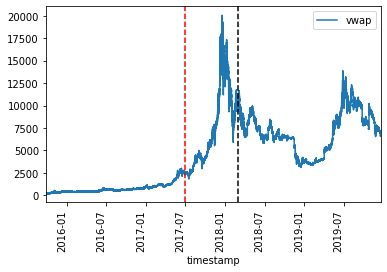

In [82]:

ax = df.plot(y="vwap",rot = 90)
ax.axvline("2018-03-01", linestyle="--", c="black")
ax.axvline("2017-07-01", linestyle="--", c='red')

In [83]:
df_vwap = df.loc[:,["vwap"]]
df_vwap.tail()

,vwap
timestamp,
2019-12-18 10:05:00+00:00,6622.0780
2019-12-18 10:10:00+00:00,6621.2011
2019-12-18 10:15:00+00:00,6628.2230
2019-12-18 10:20:00+00:00,6648.9362
2019-12-18 10:25:00+00:00,6636.1404


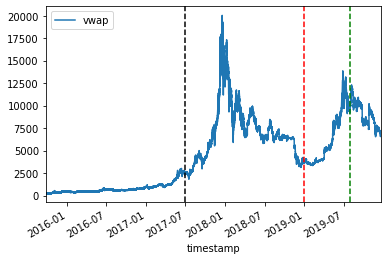

In [84]:
ax = df_vwap.plot()
ax.axvline("2017-07-01", linestyle="--", c="black")
ax.axvline("2019-01-01", linestyle="--", c='red')
ax.axvline("2019-08-01", linestyle="--", c='green')
#ax.fill_between(color='grey') #Bollinger band

Bollinger band -> https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

In [85]:
df_train = df_vwap[(df_vwap.index >= "2017-07-01")&(df_vwap.index <= "2019-01-01")]
df_train.shape

(158113, 1)

In [86]:
df_valid = df_vwap[(df_vwap.index >= "2019-01-01")&(df_vwap.index <= "2019-07-01")]
df_valid.shape

(52129, 1)

In [87]:
df_test = df_vwap[df_vwap.index < "2019-07-01"]
df_test.shape

(395855, 1)

Data Scaling

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_set = scaler.fit_transform(df_train)
test_set = scaler.fit_transform(df_test)
valid_set = scaler.fit_transform(df_valid)


In [89]:
print(len(train_set))

158113


Data Transforming

Here the feature and the target are from the same sequence. the only difference is that the target is shifted by 1 time bar.

Here we transform the long sequence of data into many shorter sequences (100 time bars per sequence) that are shifted by a single time bar.

In [0]:
from torch.autograd import Variable

def transform_data(arr, seq_len):
  x,y = [],[]
  for i in range(len(arr)-seq_len):
    x_i = arr[i: i+seq_len]
    y_i = arr[i+1:i+seq_len+1]
    x.append(x_i)
    y.append(y_i)

  x_arr = np.array(x).reshape(-1,seq_len)
  y_arr = np.array(y).reshape(-1,seq_len)
  x_var = Variable(torch.from_numpy(x_arr).float())#inputs
  y_var = Variable(torch.from_numpy(y_arr).float())
  return x_var,y_var


In [0]:
seq_len =100

x_train, y_train = transform_data(train_set, seq_len)
x_val, y_val = transform_data(valid_set,seq_len)
x_test, y_test = transform_data(test_set,seq_len)

In [0]:
def plot_sequence(axes, i, x_train, y_train):
  axes[i].set_title("%d. sequence"%(i+1))
  axes[i].set_xlabel("Time Bars")
  axes[i].set_ylabel("Scales VWAP")
  axes[i].plot(range(seq_len),x_train[i].cpu().numpy(), color='r', label='Feature') #converting Variable to numpy
  axes[i].plot(range(1,seq_len+1), y_train[i].cpu().numpy(), color='b', label='Target')
  axes[i].legend()


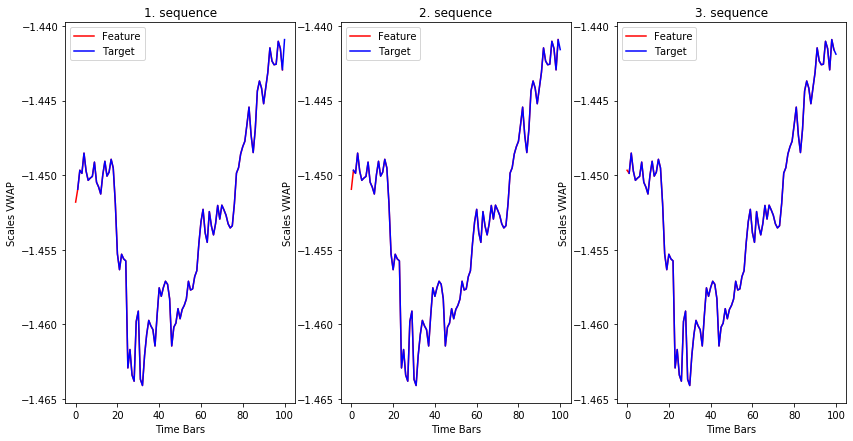

In [93]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(14,7))
plot_sequence(axes,0,x_train,y_train)
plot_sequence(axes,1,x_train,y_train)
plot_sequence(axes,2,x_train,y_train)

LSTM

In [0]:
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Model, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
    self.linear = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, future=0, y=None):
    outputs = []

    #reset the state of LSTM
    #the state is kept till the end of the sequence
    h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
    c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

    for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
      h_t, c_t = self.lstm(input_t, (h_t,c_t))
      output = self.linear(h_t)
      outputs += [output]

    for i in range(future): #teacher forcing
      if y is not None and random.random()>0.5:
        output = y[:,[i]]
      h_t, c_t = self.lstm(output,(h_t,c_t))
      output = self.linear(h_t)
      outputs += [output]
    outputs = torch.stack(outputs,1).squeeze(2)
    return outputs  

teacher forcing -> https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.


1. The problem with training recurrent neural networks that use output from prior time steps as input.
2. The teacher forcing method for addressing slow convergence and instability when training these types of recurrent networks.
3. Extensions to teacher forcing that allow trained models to better handle open loop applications of this type of network.


In [0]:
import time
import random

class Optimization:
  ''' A helper class to train, test and diagnose the LSTM '''

  def __init__(self, model, loss_fn, optimizer, scheduler):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.train_losses = []
    self.val_losses = []
    self.futures = [] #future predictions

  @staticmethod
  def generate_batch_data(x,y,batch_size):
    for batch, i in enumerate(range(0,len(x)-batch_size, batch_size)):
      x_batch = x[i:i+batch_size]
      y_batch = y[i:i+batch_size]
      #print(x_batch, y_batch, batch)
      yield x_batch, y_batch, batch

  def train(self, x_train, y_train, x_val=None, y_val=None, batch_size=100, n_epochs=10, do_teacher_forcing=None):
    seq_len = x_train.shape[1]
    for epoch in range(n_epochs):
      start_time = time.time()
      self.futures = []

      train_loss = 0
      for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
        y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
        self.optimizer.zero_grad()
        loss = self.loss_fn(y_pred, y_batch)
        loss.backward()
        self.optimizer.step()
        train_loss += loss.item()
      self.scheduler.step()
      train_loss /= batch
      self.train_losses.append(train_loss)

      self._validation(x_val, y_val, batch_size)

      elapsed = time.time() - start_time
      print("Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed))



  def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
    if do_teacher_forcing:
      future = random.randint(1, int(seq_len)/2)
      limit = x_batch.size(1) - future
      y_pred = self.model(x_batch[:,:limit], future=future, y=y_batch[:,limit:])
    else:
      future = 0
      y_pred = self.model(x_batch)
    self.futures.append(future)
    return y_pred

  def _validation(self, x_val, y_val, batch_size):
    if x_val is None or y_val is None:
      return
    with torch.no_grad():
      val_loss = 0
      for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
        y_pred = self.model(x_batch)
        loss = self.loss_fn(y_pred, y_batch)
        val_loss += loss.item()
      val_loss /= batch
      self.val_losses.append(val_loss)

  def evaluate(self, x_test, y_test, batch_size, future=1):
    with torch.no_grad():
      test_loss = 0
      actual, predicted = [],[]
      for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
        y_pred = self.model(x_batch, future=future)
        y_pred = (y_pred[:, -len(y_batch) :] if y_pred.shape[1]>y_batch.shape[1] else y_pred)
        loss = self.loss_fn(y_pred, y_batch)
        test_loss += loss.item()
        actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
        predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
      test_loss /= batch
      return actual, predicted, test_loss

  def plot_losses(self):
    plt.plot(self.train_losses, label="Training Loss")
    plt.plot(self.val_losses, label="Validation Loss")
    plt.legend()
    plt.title("Losses")

In [0]:
def generate_sequence(scaler, model, x_sample, future=1000):
  ''' Generate future values for x_sample with the model'''
  y_pred_tensor = model(x_sample, future=future)
  y_pred = y_pred_tensor.cpu().tolist()
  y_pred = scaler.inverse_transform(y_pred)
  return y_pred

In [0]:
def to_dataframe(actual,predicted):
  return pd.DataFrame({"actual":actual, "predicted":predicted})

def inverse_transform(scaler, df, columns):
  for col in columns:
    df[col] = scaler.inverse_transform(df[col])
  return df

In [124]:
model_0 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_0 = nn.MSELoss()
optimizer_0 = optim.Adam(model_0.parameters(), lr=1e-6)
scheduler_0 = optim.lr_scheduler.StepLR(optimizer_0, step_size=5, gamma=0.1)
optimization_0 = Optimization(model_0, loss_fn_0, optimizer_0, scheduler_0)

optimization_0.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: nan. Validation loss: nan. Avg future: 0.00. Elapsed time: 126.01s.


KeyboardInterrupt: ignored

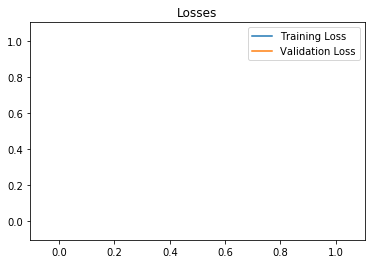

In [125]:
optimization_0.plot_losses()

Testing


Test loss nan


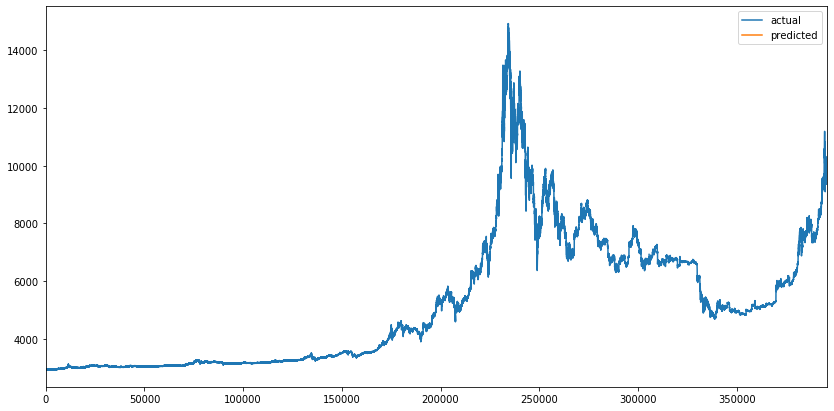

In [128]:
actual_1, predicted_1, test_loss_1 = optimization_0.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)


Zooming

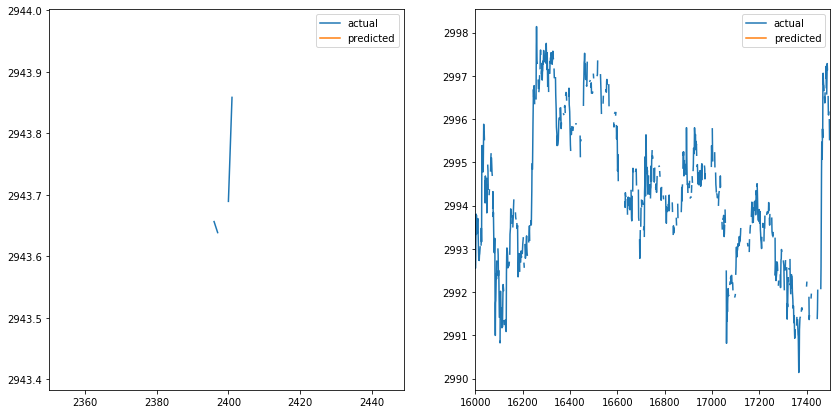

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))


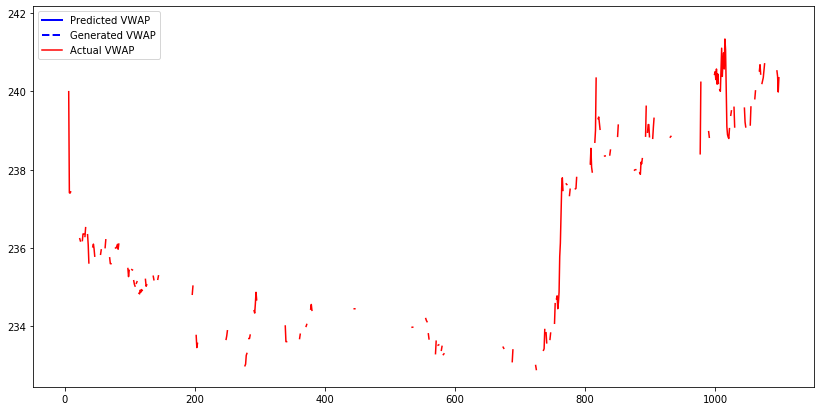

In [131]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_0.model, x_sample)
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()


Bug Fixing

In [113]:
#Adding clip gradient norm
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
clip_value = 1
loss_fn_0 = nn.MSELoss()

clip_0 = torch.nn.utils.clip_grad_norm(model_1.parameters(),clip_value)
# optimizer_0 = optim.Adam()?
scheduler_0 = optim.lr_scheduler.StepLR(clip_0, step_size=5, gamma=0.1)
optimization_0 = Optimization(model_1, loss_fn_0, clip_0, scheduler_0)

optimization_0.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  """


TypeError: ignored

Basic operations

In [23]:
import torch

t = torch.ones(2,1,2,1) #ones
print(t)
t = torch.squeeze(t)
print(t)

tensor([[[[1.],
          [1.]]],


        [[[1.],
          [1.]]]])
tensor([[1., 1.],
        [1., 1.]])


In [30]:
t1 = torch.Tensor([[[1,2,3],[2,3,5]]]) #tensor
print(t1)

tensor([[[1., 2., 3.],
         [2., 3., 5.]]])


In [39]:
t1 = torch.squeeze(t1) #squeeze
print(t1)

tensor([[1., 2., 3.],
        [2., 3., 5.]])


In [48]:
t2 = torch.unsqueeze(t1,0) #unsqueeze
t3 = torch.unsqueeze(t1,1)
t4 = torch.unsqueeze(t1,2)
#t5 = torch.unsqueeze(t1,3)
print(t1)
print(t1.size())
print(t2)
print(t2.size())
print(t3)
print(t3.size())
print(t4)
print(t4.size())


tensor([[1., 2., 3.],
        [2., 3., 5.]])
torch.Size([2, 3])
tensor([[[1., 2., 3.],
         [2., 3., 5.]]])
torch.Size([1, 2, 3])
tensor([[[1., 2., 3.]],

        [[2., 3., 5.]]])
torch.Size([2, 1, 3])
tensor([[[1.],
         [2.],
         [3.]],

        [[2.],
         [3.],
         [5.]]])
torch.Size([2, 3, 1])


In [41]:
p = torch.ones(4,3)
print(p)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [52]:
p1 = torch.squeeze(p,1)
print(p1)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [53]:
print(p.size()) #size()
print(p1.size())

torch.Size([4, 3])
torch.Size([4, 3])


In [55]:
p2 = torch.stack([p]) #stack
print(p2)

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])


In [56]:
print(p2.size())

torch.Size([1, 4, 3])


In [57]:
p3 = torch.stack([p],1)
print(p3)

tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]])


In [58]:
print(p3.size())

torch.Size([4, 1, 3])


In [61]:
print(p)
print(p.size())
p4 = p.chunk(4)
print(p4)
# print(p4.size()) #tuple has no attribute size

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
torch.Size([4, 3])
(tensor([[1., 1., 1.]]), tensor([[1., 1., 1.]]), tensor([[1., 1., 1.]]), tensor([[1., 1., 1.]]))
